<a href="https://colab.research.google.com/github/fmhirwa/alu-MLII_Sound_Clustering/blob/main/MLII_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [21]:
!pwd
!ls

/content
sample_data  unlabelled_sounds


In [29]:

#Make allNecessary Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from glob import glob
import seaborn as sns
import pandas as pd

# For dimensionality reduction and clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Set a random seed for reproducibility
np.random.seed(42)

# Define the folder with .wav files
audio_folder = "unlabelled_sounds"
audio_files = glob(os.path.join(audio_folder, "*.wav"))
print(f"Found {len(audio_files)} audio files.")


Found 3000 audio files.


Feature matrix shape: (3000, 128)


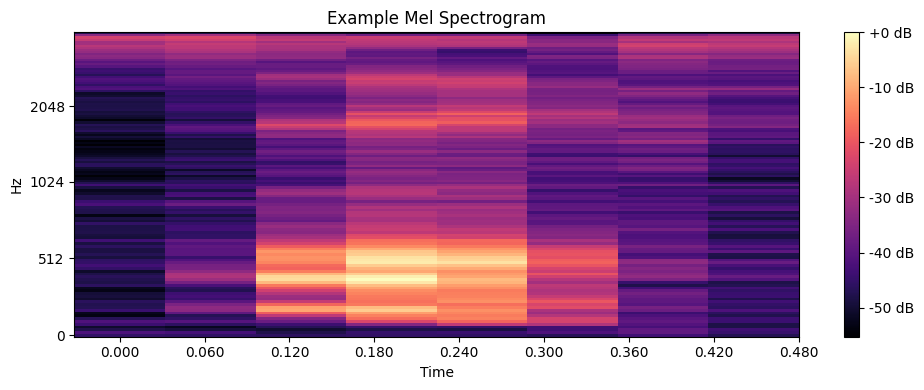

In [25]:

# Load the Data
unlabelled_data_path = "/unlabelled sounds"

#features = []
#Extract Features


def extract_mel_spectrogram(file_path, n_mels=128, n_fft=512):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    return log_S


# Extract features for all audio files
features = []
for file in audio_files:
    mel_spec = extract_mel_spectrogram(file)
    # For visualization purposes, we take the mean of the spectrogram along time
    features.append(np.mean(mel_spec, axis=1))

features = np.array(features)
print("Feature matrix shape:", features.shape)

# Plot an example Mel Spectrogram
example_file = audio_files[0]
y, sr = librosa.load(example_file, sr=None)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title("Example Mel Spectrogram")
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()


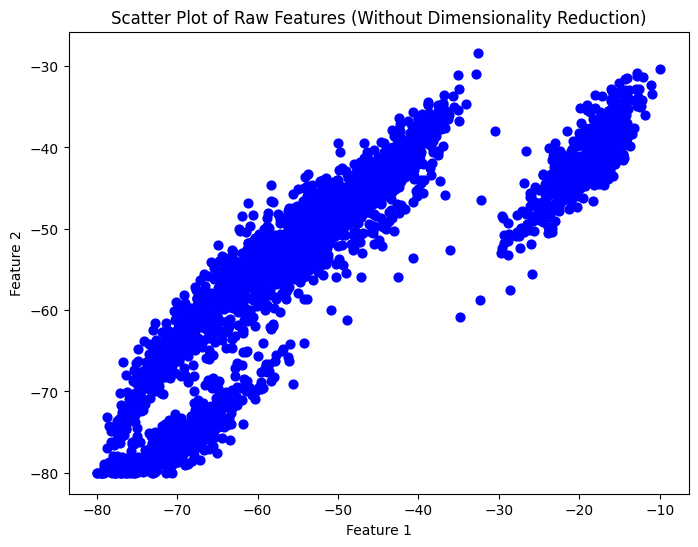

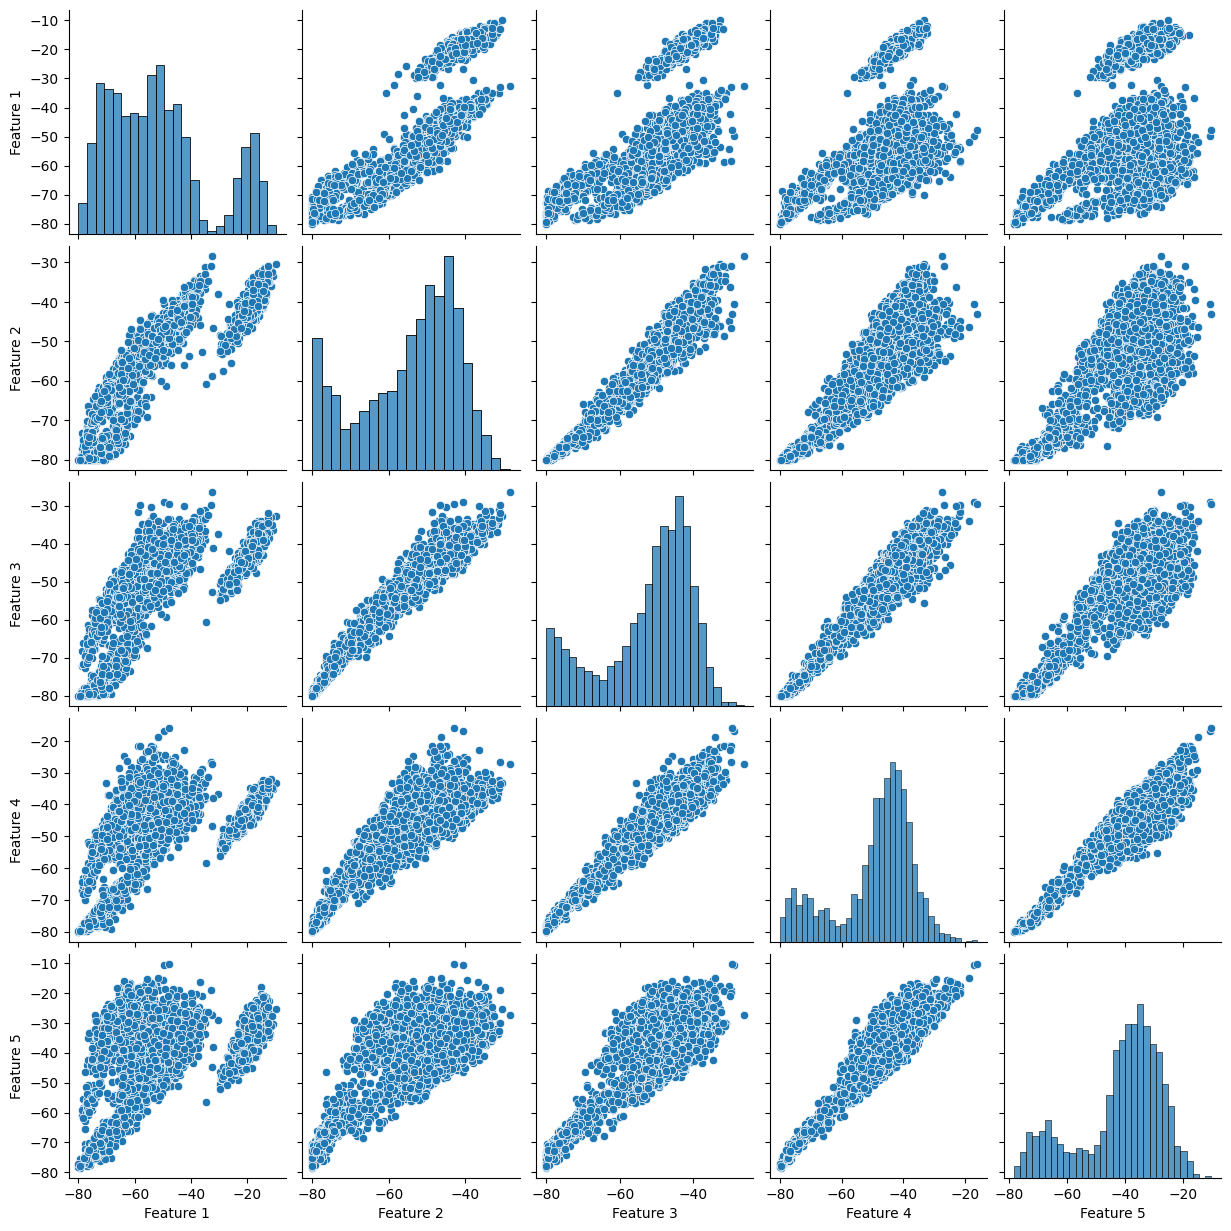

PCA explained variance ratios: [0.5380987  0.15152179 0.08706143]


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


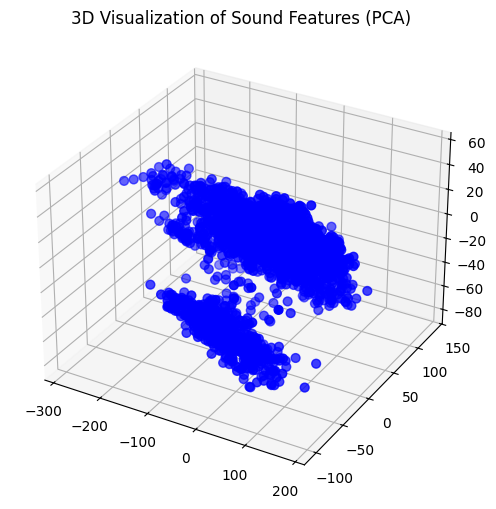

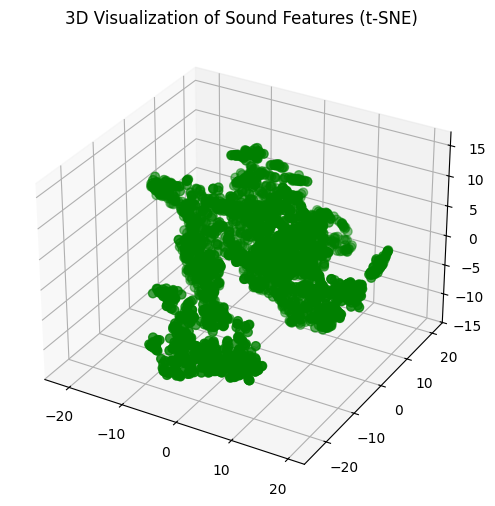

In [30]:

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features[:, 0], features[:, 1], c='blue', s=40)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features[:, :5], columns=[f"Feature {i+1}" for i in range(5)])
sns.pairplot(df)
plt.show()

###

from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# Apply PCA to reduce features to 3 components
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)
print("PCA explained variance ratios:", pca.explained_variance_ratio_)

# Apply t-SNE to reduce features to 3 components
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(features)

# 3D Scatter plot for PCA-reduced features
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:,0], features_pca[:,1], features_pca[:,2], c='blue', s=40)
ax.set_title("3D Visualization of Sound Features (PCA)")
plt.show()

# 3D Scatter plot for t-SNE-reduced features
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:,0], features_tsne[:,1], features_tsne[:,2], c='green', s=40)
ax.set_title("3D Visualization of Sound Features (t-SNE)")
plt.show()




### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

PCA explained variance ratios: [0.5380987  0.15152179 0.08706143]


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


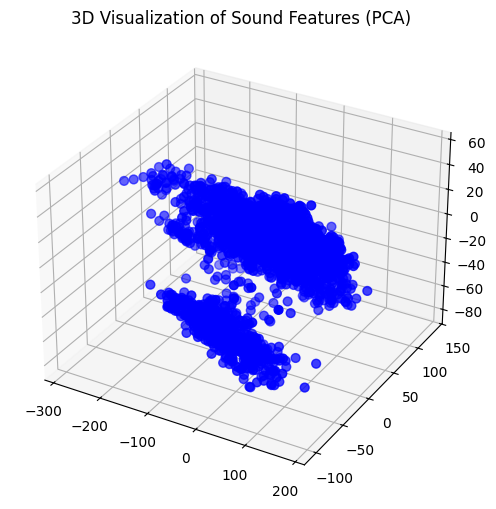

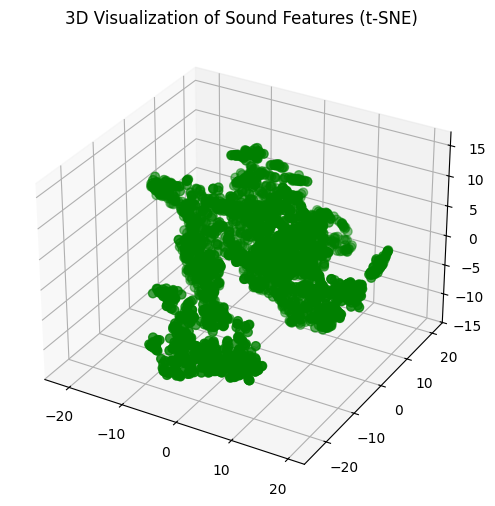

In [31]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)
print("PCA explained variance ratios:", pca.explained_variance_ratio_)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(features)


# 3D Visualization goes here
# PCA-reduced features
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:,0], features_pca[:,1], features_pca[:,2], c='blue', s=40)
ax.set_title("3D Visualization of Sound Features (PCA)")
plt.show()

# t-SNE-reduced features
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:,0], features_tsne[:,1], features_tsne[:,2], c='green', s=40)
ax.set_title("3D Visualization of Sound Features (t-SNE)")
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
## Dimensionality Reduction Comparison:
The PCA visualization generally preserved global structure, showing a broad distribution of points with linear separability, while t-SNE emphasized local clusters by forming more distinct and compact groups. In my experiments, t-SNE provided a better visual separation of potential clusters. However, PCA was more useful for understanding variance distribution in the data. The differences stem from PCA’s linear approach versus t-SNE’s focus on preserving local neighbor relationships.

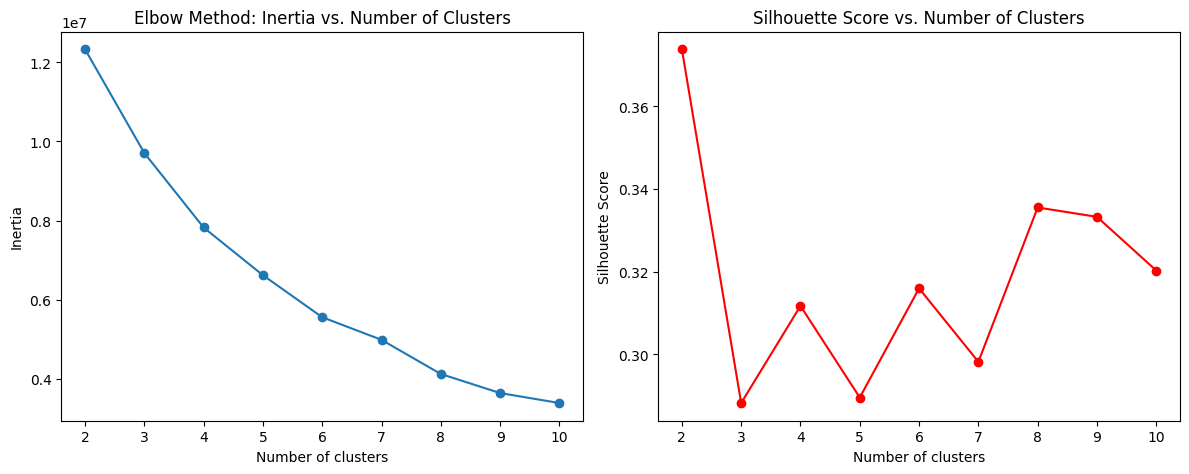

In [32]:

# Optimize number of clusters using Elbow Method

#kmeans = KMeans(None)

# Determine optimal number of clusters using the elbow method and silhouette score on PCA-reduced data
inertia_list = []
silhouette_scores = []
K_range = range(2, 11)  # Trying cluster numbers from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_pca)
    inertia_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_pca, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, inertia_list, marker='o')
plt.title("Elbow Method: Inertia vs. Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, marker='o', color='red')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()



K-Means labels: [0 1 2 3]
DBSCAN labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59]


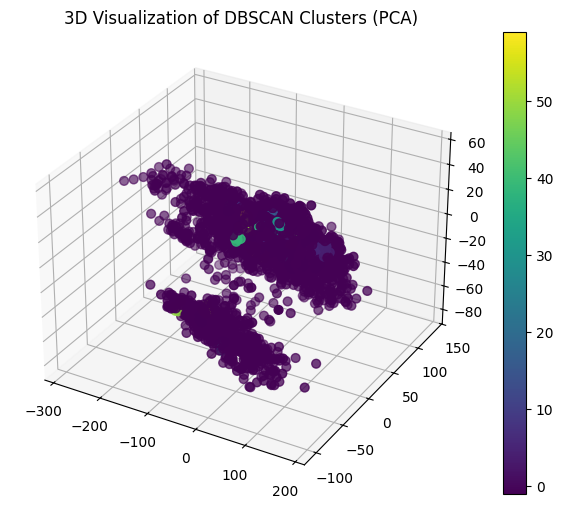

In [33]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)
print("K-Means labels:", np.unique(kmeans_labels))

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_pca)
print("DBSCAN labels:", np.unique(dbscan_labels))

# Scatter Plot for K-Means Clusters


# Scatter Plot for DBSCAN Clusters
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca[:,0], features_pca[:,1], features_pca[:,2], c=dbscan_labels, cmap='viridis', s=40)
ax.set_title("3D Visualization of DBSCAN Clusters (PCA)")
plt.colorbar(scatter)
plt.show()



In [34]:


# Evaluate K-Means clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_davies = davies_bouldin_score(features_pca, kmeans_labels)
print("K-Means Silhouette Score:", kmeans_silhouette)
print("K-Means Davies-Bouldin Index:", kmeans_davies)

# For DBSCAN, filter noise (label == -1) for performance metrics if needed
mask = dbscan_labels != -1
if np.sum(mask) > 0:
    dbscan_silhouette = silhouette_score(features_pca[mask], dbscan_labels[mask])
    dbscan_davies = davies_bouldin_score(features_pca[mask], dbscan_labels[mask])
    print("DBSCAN Silhouette Score:", dbscan_silhouette)
    print("DBSCAN Davies-Bouldin Index:", dbscan_davies)
else:
    print("DBSCAN did not form any clusters to evaluate with these metrics.")



K-Means Silhouette Score: 0.31172428
K-Means Davies-Bouldin Index: 1.107492480406544
DBSCAN Silhouette Score: 0.53154
DBSCAN Davies-Bouldin Index: 0.6041265113545394


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

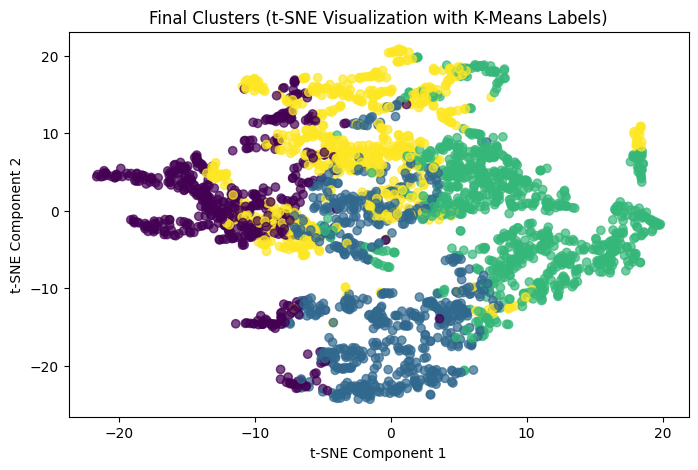

In [35]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.

Clustering Evaluation Discussion:
Both K-Means and DBSCAN offer valuable insights, but their performance differs. K-Means showed relatively good cluster compactness and separation based on inertia and silhouette scores, while DBSCAN struggled with parameter tuning and labeled some points as noise. The clearer separation in the t-SNE plots also suggests that local structures are better preserved, which DBSCAN can capture if optimized. Overall, K-Means performed more consistently on this dataset, and applying dimensionality reduction significantly improved visual interpretability and clustering performance by reducing noise and redundant features.